Found 1054 frames with face detections


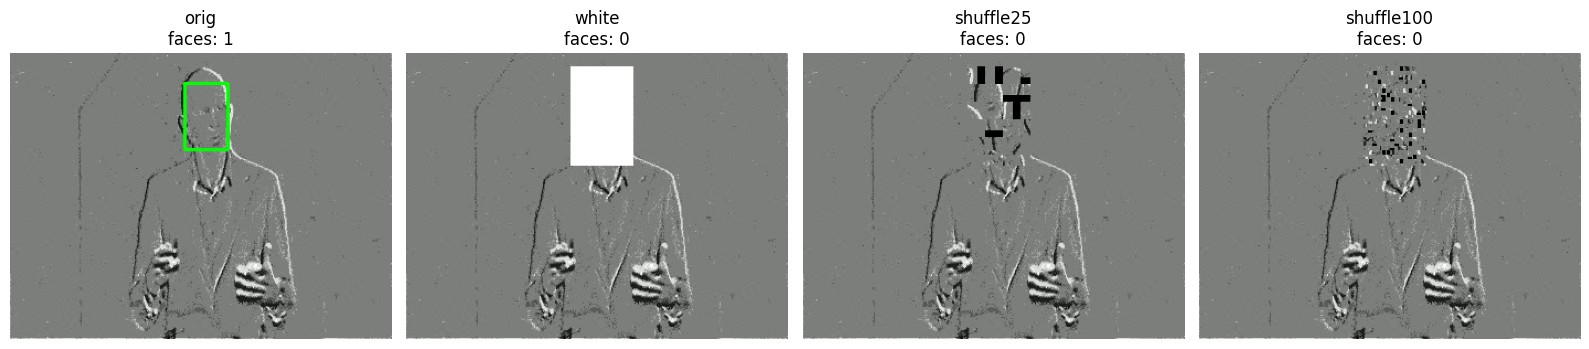

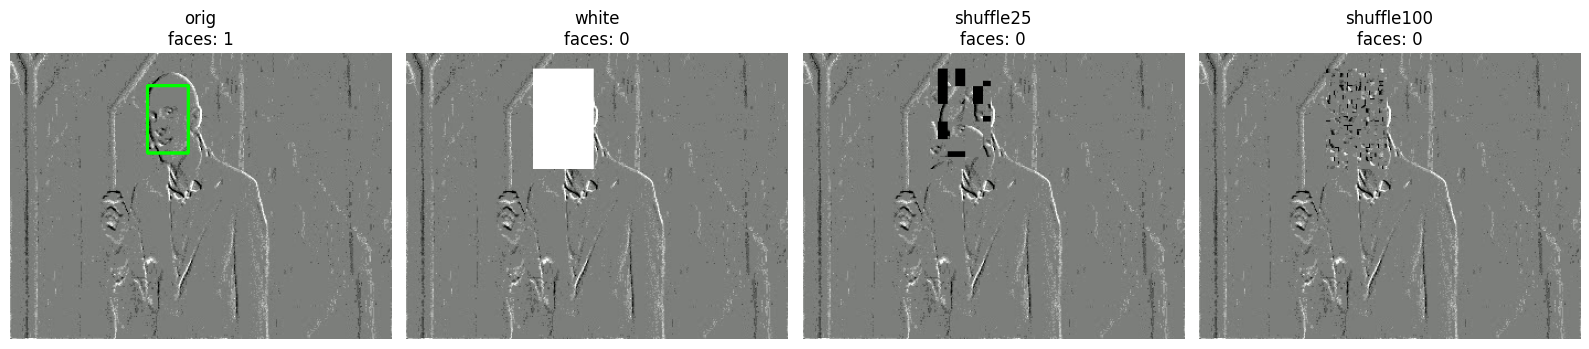

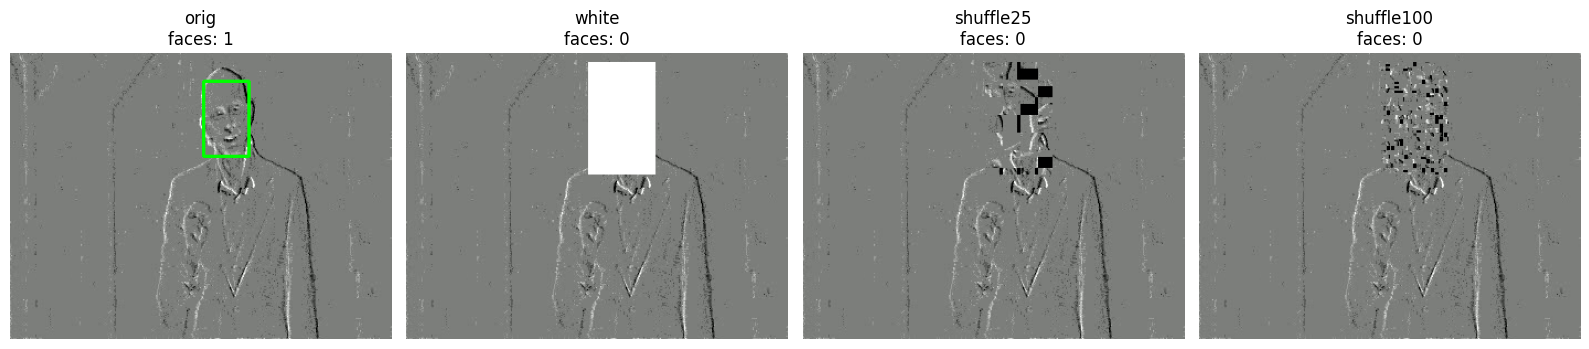

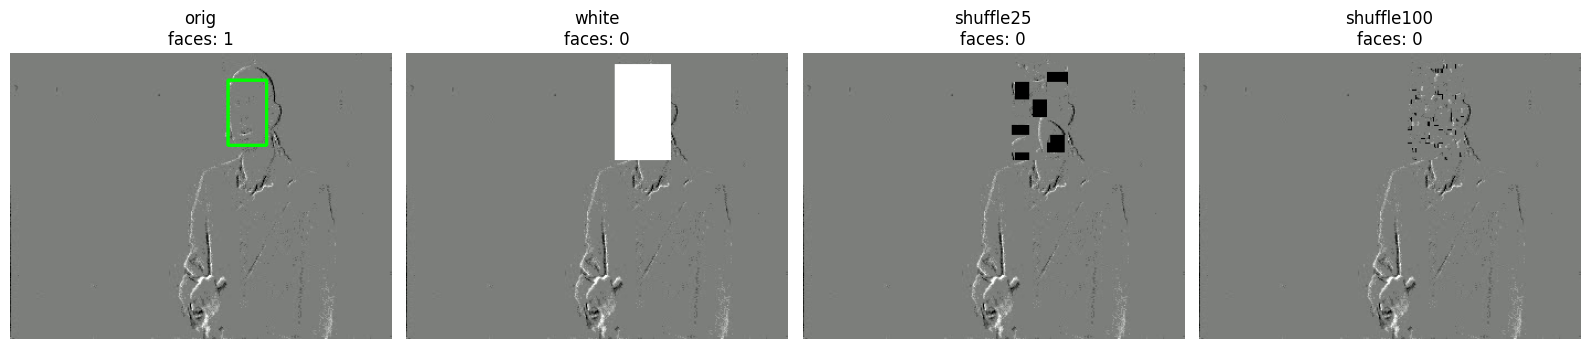

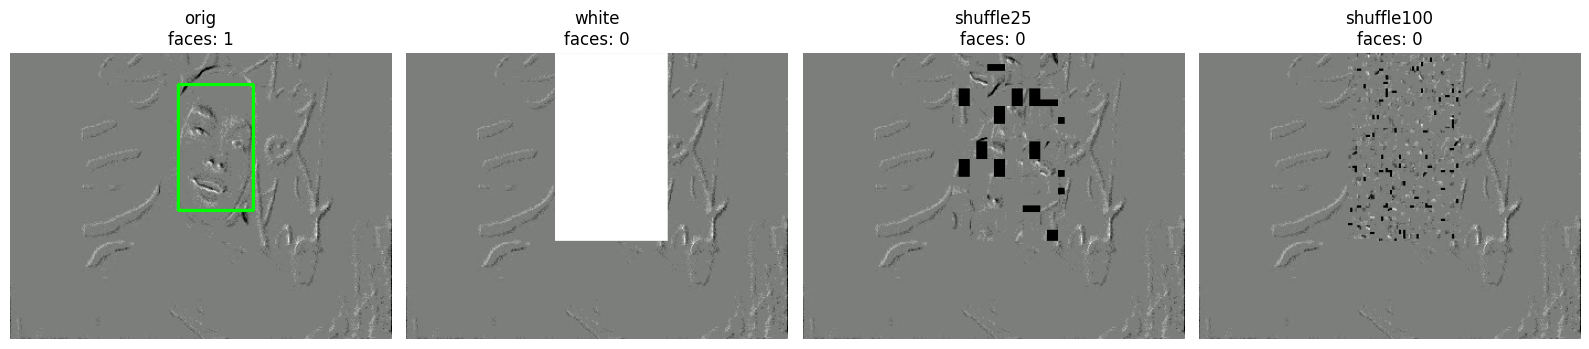

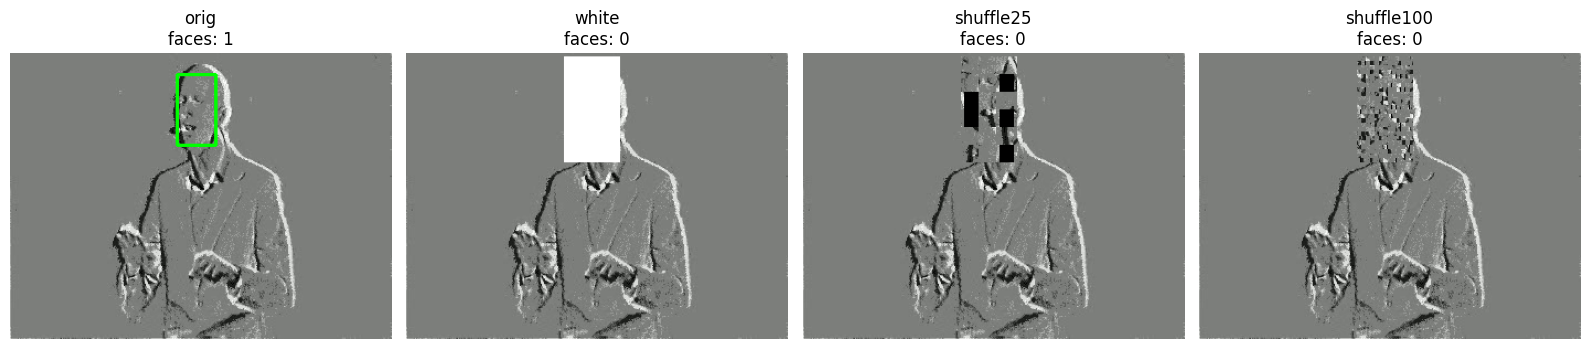

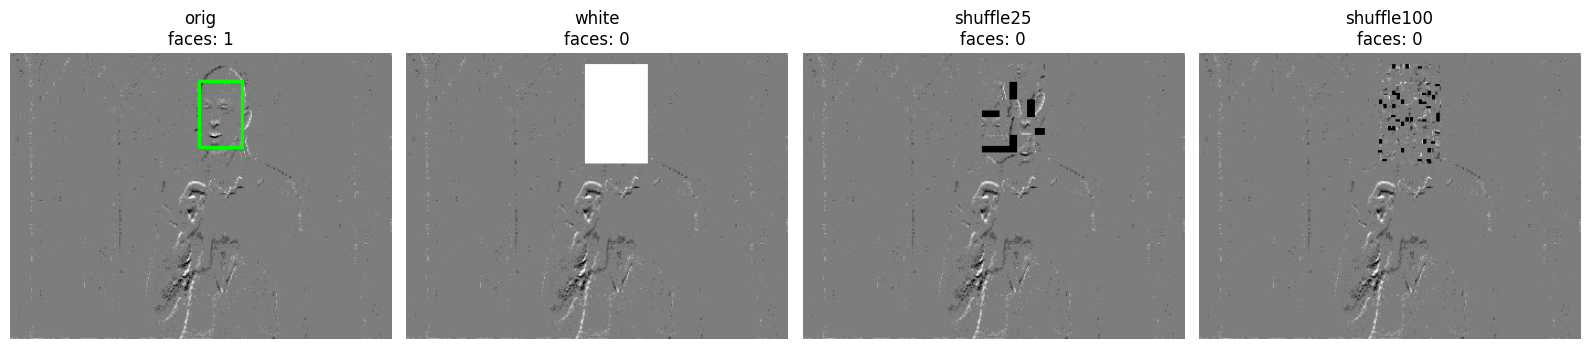

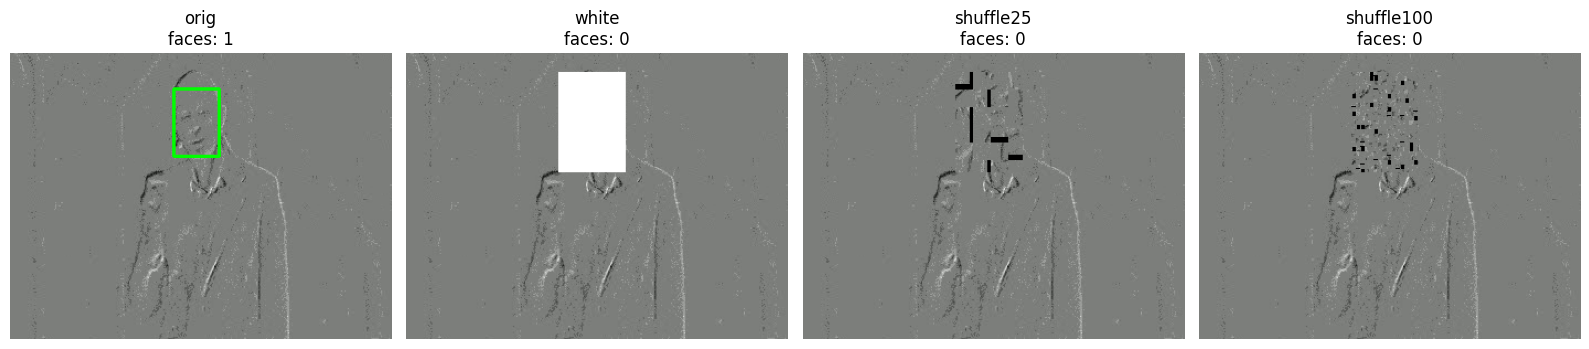

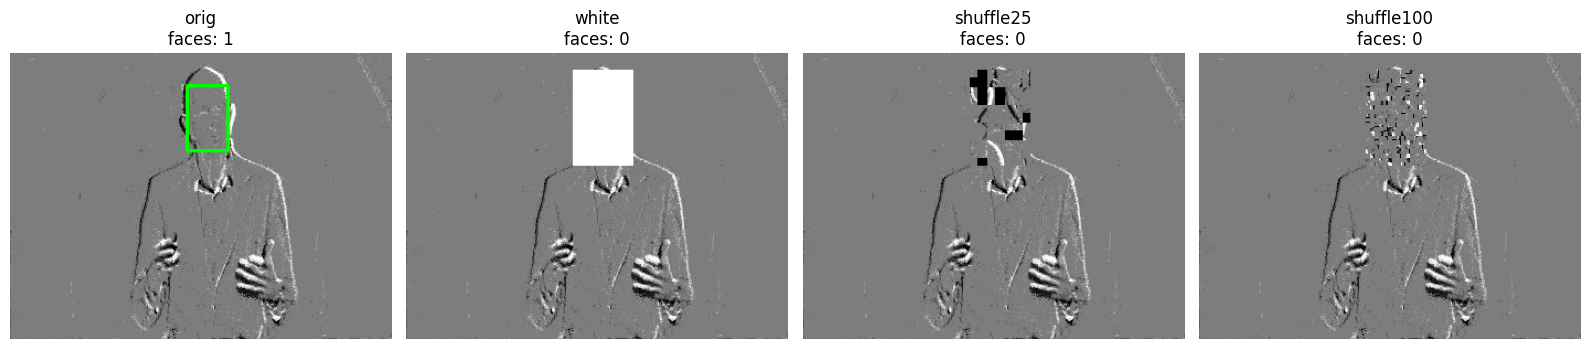

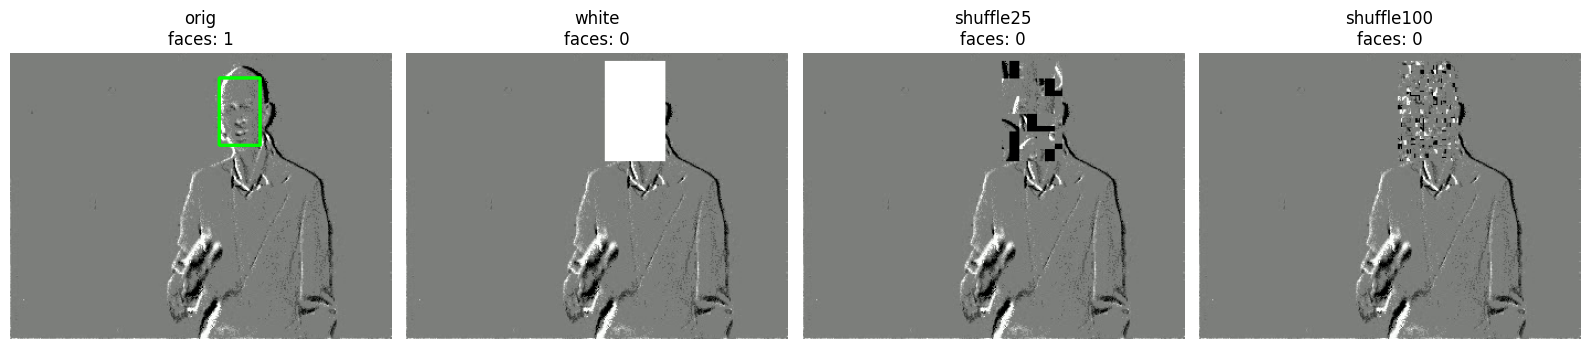

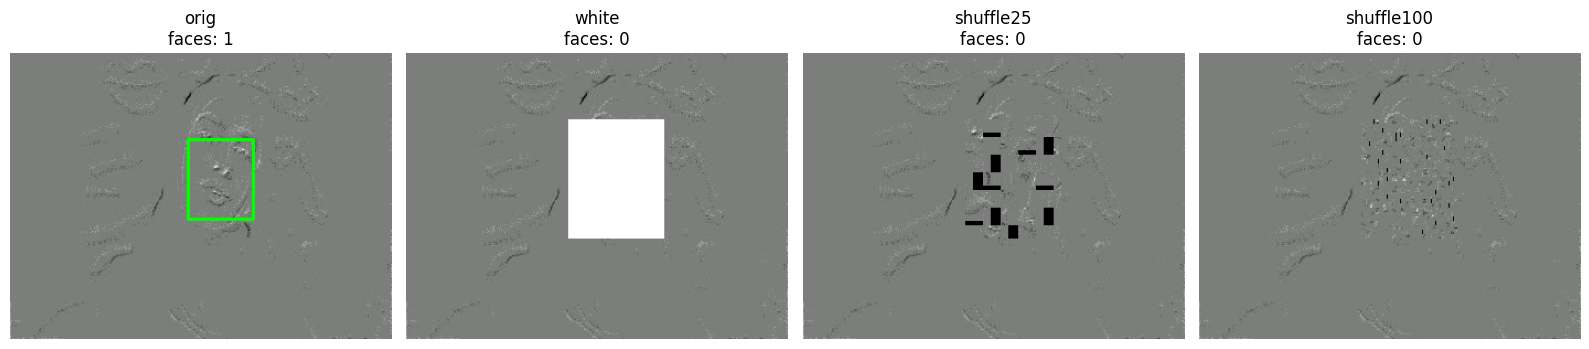

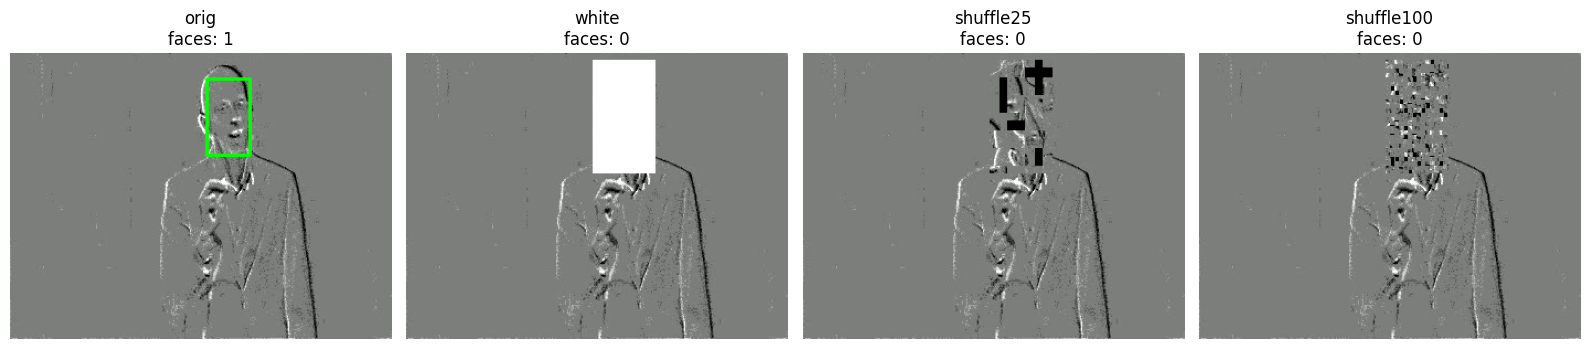

In [ ]:
import cv2
import matplotlib.pyplot as plt
import random
import numpy as np

def shuffle_face(img, box, patch_size=8):
    x_min, y_min, x_max, y_max = map(int, box)
    face = img[y_min:y_max, x_min:x_max].copy()
    h, w, c = face.shape


    patches, positions = [], []
    for i in range(0, h, patch_size):
        for j in range(0, w, patch_size):
            i_end = min(i + patch_size, h)
            j_end = min(j + patch_size, w)
            patch = face[i:i_end, j:j_end].copy()
            patches.append(patch)
            positions.append((i, i_end, j, j_end))

    random.shuffle(patches)


    face_copy = np.zeros_like(face)
    for idx, (i, i_end, j, j_end) in enumerate(positions):
        patch = patches[idx]
        h_patch, w_patch, _ = patch.shape
        h_slice = min(h_patch, i_end - i)
        w_slice = min(w_patch, j_end - j)
        face_copy[i:i+h_slice, j:j+w_slice] = patch[:h_slice, :w_slice]

    img_copy = img.copy()
    img_copy[y_min:y_max, x_min:x_max] = face_copy
    return img_copy


def expand_box(box, img_shape, margin=0.25):
    h, w = img_shape[:2]
    x_min, y_min, x_max, y_max = map(int, box)
    w_box, h_box = x_max - x_min, y_max - y_min
    x_min = max(0, x_min - int(margin * w_box))
    y_min = max(0, y_min - int(margin * h_box))
    x_max = min(w, x_max + int(margin * w_box))
    y_max = min(h, y_max + int(margin * h_box))
    return [x_min, y_min, x_max, y_max]

def draw_boxes(img, boxes, color=(0,255,0), thickness=2):
    img = img.copy()
    for box in boxes:
        x1, y1, x2, y2 = map(int, box)
        cv2.rectangle(img, (x1,y1), (x2,y2), color, thickness)
    return img

valid_examples = []

for row in results:
    if row["orig_detections"] > 0:
        valid_examples.append(row)

print(f"Found {len(valid_examples)} frames with face detections")


num_samples = 12
samples = random.sample(valid_examples, num_samples)

for s in samples:
    frame_idx = s["frame"]
    img_path = f"/content/event_frames/{frame_idx}"


    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    preds = face_model.predict(img, verbose=False)
    if len(preds) == 0 or preds[0].boxes is None or len(preds[0].boxes.xyxy) == 0:
        continue
    gt_box = preds[0].boxes.xyxy[0].cpu().numpy()

    exp_box = expand_box(gt_box, img.shape, margin=0.25)

    imgs = {
        "orig": img,
        "white": white_out_face(img.copy(), exp_box),
        "shuffle25": shuffle_face(img.copy(), exp_box, patch_size=16),
        "shuffle100": shuffle_face(img.copy(), exp_box, patch_size=4),
    }

    fig, axs = plt.subplots(1, 4, figsize=(16,4))

    for ax, (title, im) in zip(axs, imgs.items()):
        preds = face_model.predict(im, verbose=False)
        boxes = preds[0].boxes.xyxy.cpu().numpy() if preds[0].boxes is not None else []

        vis = draw_boxes(im, boxes)
        ax.imshow(vis)
        ax.set_title(f"{title}\nfaces: {len(boxes)}")
        ax.axis("off")

    plt.tight_layout()
    plt.show()

In [1]:
# Import Libraries

!pip install -U ultralytics opencv-python matplotlib pandas tqdm --quiet

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from ultralytics import YOLO
import cv2, os, pandas as pd
import random
import time

face_model = YOLO("yolov8n-face.pt")


def white_out_face(img, box):
    x_min, y_min, x_max, y_max = map(int, box)
    img_copy = img.copy()
    img_copy[y_min:y_max, x_min:x_max] = 255
    return img_copy

def shuffle_face(img, box, patch_size=8):
    x_min, y_min, x_max, y_max = map(int, box)
    face = img[y_min:y_max, x_min:x_max].copy()
    h, w, c = face.shape

    patches, positions = [], []
    for i in range(0, h, patch_size):
        for j in range(0, w, patch_size):
            i_end = min(i + patch_size, h)
            j_end = min(j + patch_size, w)
            patch = face[i:i_end, j:j_end].copy()
            patches.append(patch)
            positions.append((i, i_end, j, j_end))

    random.shuffle(patches)

    # put patches back safely
    face_copy = np.zeros_like(face)
    for idx, (i, i_end, j, j_end) in enumerate(positions):
        patch = patches[idx]
        h_patch, w_patch, _ = patch.shape
        h_slice = min(h_patch, i_end - i)
        w_slice = min(w_patch, j_end - j)
        face_copy[i:i+h_slice, j:j+w_slice] = patch[:h_slice, :w_slice]

    img_copy = img.copy()
    img_copy[y_min:y_max, x_min:x_max] = face_copy
    return img_copy

def expand_box(box, img_shape, margin=0.25):
    h, w = img_shape[:2]
    x_min, y_min, x_max, y_max = map(int, box)
    w_box, h_box = x_max - x_min, y_max - y_min
    x_min = max(0, x_min - int(margin * w_box))
    y_min = max(0, y_min - int(margin * h_box))
    x_max = min(w, x_max + int(margin * w_box))
    y_max = min(h, y_max + int(margin * h_box))
    return [x_min, y_min, x_max, y_max]

def compute_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0]); yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2]); yB = min(boxA[3], boxB[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    areaA = (boxA[2] - boxA[0])*(boxA[3] - boxA[1])
    areaB = (boxB[2] - boxB[0])*(boxB[3] - boxB[1])
    union = areaA + areaB - interArea
    return interArea / union if union > 0 else 0.0

def best_iou_from_predictions(pred_boxes, gt_box):
    if len(pred_boxes) == 0: return 0.0
    return max(compute_iou(pred, gt_box) for pred in pred_boxes)

video_dir = "/content/avi_videos"
frame_dir = "/content/event_frames"

# Create video_dir if it doesn't exist
os.makedirs(video_dir, exist_ok=True)
os.makedirs(frame_dir, exist_ok=True)



frame_list = []
frame_count = 0

video_files = [f for f in os.listdir(video_dir) if f.endswith('.avi')]
if not video_files:
    print(f"No .avi video files found in {video_dir}. Please upload some .avi videos to this directory.")
else:
    for video_file in video_files:
        path = os.path.join(video_dir, video_file)
        cap = cv2.VideoCapture(path)
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            frame_path = os.path.join(frame_dir, f"frame_{frame_count:06d}.png")
            cv2.imwrite(frame_path, frame)
            frame_list.append(frame_path)
            frame_count += 1
        cap.release()

    print(f"Extracted {len(frame_list)} frames.")
# --------------------------------------------------------

# Compute patch size from shuffle fraction
def patch_size_from_fraction(box, fraction):
    x_min, y_min, x_max, y_max = map(int, box)
    w = x_max - x_min
    h = y_max - y_min
    patch = max(2, int(min(w, h) * fraction))
    return patch

# Shuffle Fractions
shuffle_fractions = [
    0.0,
    0.03,
    0.05,
    0.08,
    0.16,
    0.20,
    0.25,
    0.50,
    0.75,
    0.90,
    1.0
]

shuffle_levels = [0, 3, 5, 8, 16, 20, 25, 50, 75, 90, 100]

results = []

if frame_list:
    for idx, frame_path in tqdm(enumerate(frame_list), total=len(frame_list)):
        img = cv2.imread(frame_path)
        if img is None: continue

        preds_orig = face_model.predict(img, verbose=False)
        if len(preds_orig) == 0 or preds_orig[0].boxes is None or len(preds_orig[0].boxes.xyxy) == 0:
            continue

        gt_box = preds_orig[0].boxes.xyxy[0].cpu().numpy()
        exp_box = expand_box(gt_box, img.shape, margin=0.25)

        variants = {}
        timings = {} # Dictionary to store timing for this frame

        for frac in shuffle_fractions:
            key = "orig" if frac == 0.0 else f"shuffle{int(frac*100)}"

            start_t = time.perf_counter()

            if frac == 0.0:
                variants[key] = img.copy()
            elif frac == 1.0:
                variants[key] = shuffle_face(img.copy(), exp_box, patch_size=4)
            else:
                patch = patch_size_from_fraction(exp_box, 1-frac)
                variants[key] = shuffle_face(img.copy(), exp_box, patch_size=patch)

            # Record in ms
            timings[f"{key}_time_ms"] = (time.perf_counter() - start_t) * 1000


        start_t = time.perf_counter()
        variants["white"] = white_out_face(img.copy(), exp_box)
        timings["white_time_ms"] = (time.perf_counter() - start_t) * 1000


        row = {"frame": os.path.basename(frame_path)}
        row.update(timings) # Add timing data to the CSV row

        for key, var_img in variants.items():
            preds_var = face_model.predict(var_img, verbose=False)
            pred_boxes = preds_var[0].boxes.xyxy.cpu().numpy() if len(preds_var) > 0 and preds_var[0].boxes is not None else []

            iou = best_iou_from_predictions(pred_boxes, gt_box)
            row[f"{key}_iou"] = iou
            row[f"{key}_privacy"] = 1.0 - iou
            row[f"{key}_detections"] = len(pred_boxes)

        results.append(row)

    # Save to CSV
    df_results = pd.DataFrame(results)
    df_results.to_csv("/content/event_video_results.csv", index=False)

    # Plot Execution Time
    df_mean = df_results.select_dtypes(include=np.number).mean()
    time_cols = [
        'orig_time_ms',
        'shuffle3_time_ms',
        'shuffle5_time_ms',
        'shuffle8_time_ms',
        'shuffle16_time_ms',
        'shuffle20_time_ms',
        'shuffle25_time_ms',
        'shuffle50_time_ms',
        'shuffle75_time_ms',
        'shuffle90_time_ms',
        'shuffle100_time_ms'
    ]

    shuffle_levels = [0, 3, 5, 8, 16, 20, 25, 50, 75, 90, 100]
    plt.figure(figsize=(8,5))
    plt.plot(shuffle_levels, [df_mean[col] for col in time_cols], marker='s', color='green', label="Shuffling Overhead")
    plt.xlabel("Shuffling Level (%)")
    plt.ylabel("Execution Time (ms)")
    plt.title("Computational Cost vs Shuffling Level")
    plt.legend()
    plt.grid(True)
    plt.show()

    # 2️⃣ Define the shuffle levels




    detection_cols = [
        'orig_detections',
        'shuffle3_detections',
        'shuffle5_detections',
        'shuffle8_detections',
        'shuffle16_detections',
        'shuffle20_detections',
        'shuffle25_detections',
        'shuffle50_detections',
        'shuffle75_detections',
        'shuffle90_detections',
        'shuffle100_detections'
    ]



    iou_cols = [
        'orig_iou',
        'shuffle3_iou',
        'shuffle5_iou',
        'shuffle8_iou',
        'shuffle16_iou',
        'shuffle20_iou',
        'shuffle25_iou',
        'shuffle50_iou',
        'shuffle75_iou',
        'shuffle90_iou',
        'shuffle100_iou'
    ]




    # Plot face detections
    plt.figure(figsize=(8,5))
    plt.plot(shuffle_levels, [df_mean[col] for col in detection_cols], marker='o', label="Shuffling")
    plt.axhline(y=df_mean['white_detections'], color='r', linestyle='--', label="White-out")
    plt.xlabel("Shuffling Level (%)")
    plt.ylabel("Avg Faces Detected")
    plt.title("Face Detection vs Shuffling (Event Videos)")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot IoU / privacy
    plt.figure(figsize=(8,5))
    plt.plot(shuffle_levels, [df_mean[col] for col in iou_cols], marker='o', color='purple', label="Mean IoU")
    plt.axhline(y=df_mean['white_iou'], color='r', linestyle='--', label="White-out IoU")
    plt.xlabel("Shuffling Level (%)")
    plt.ylabel("Mean Face IoU")
    plt.title("Face IoU vs Shuffling Level (Event Videos)")
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("Skipping pipeline and plotting as no frames were extracted.")



ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/commands/install.py", line 377, in run
    requirement_set = resolver.resolve(
                      ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/resolution/resolvelib/resolver.py", line 95, in resolve
    result = self._result = resolver.resolve(
                            ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_vendor/resolvelib/resolvers.py", line 546, in resolve
    state = resolution.resolve(requirements, max_rounds=max_rounds)
            

ModuleNotFoundError: No module named 'ultralytics'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.0/35.0 MB 24.2 MB/s eta 0:00:00
Fitted parameters:
a=0.851, b=5.000, c=0.149, d=0.043


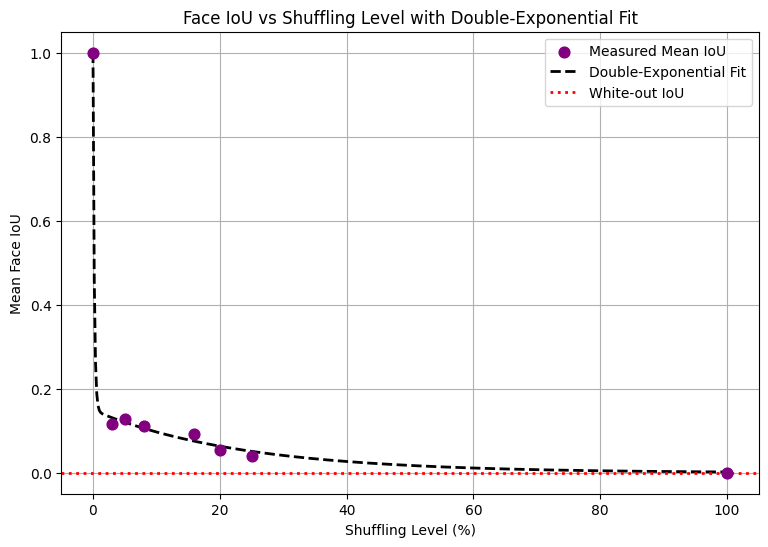

R² of fit: 0.9990


In [ ]:
# Import Libraries
!pip install -U scipy matplotlib pandas --quiet

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Load Results
csv_path = "/content/event_video_results.csv"
df_results = pd.read_csv(csv_path)


numeric_cols = df_results.select_dtypes(include=np.number).columns
df_mean = df_results[numeric_cols].mean()


shuffle_levels = np.array([0, 3, 5, 8, 16, 20, 25, 100], dtype=float)

iou_cols = [
    "orig_iou",
    "shuffle3_iou",
    "shuffle5_iou",
    "shuffle8_iou",
    "shuffle16_iou",
    "shuffle20_iou",
    "shuffle25_iou",
    "shuffle100_iou"
]

# Extract IoU
mean_iou = np.array([df_mean[col] for col in iou_cols])


def double_exponential(x, a, b, c, d):
    return a * np.exp(-b * x) + c * np.exp(-d * x)


initial_guess = [0.7, 0.2, 0.3, 0.01]

params, _ = curve_fit(
    double_exponential,
    shuffle_levels,
    mean_iou,
    p0=initial_guess,
    bounds=(0, 5)
)

a, b, c, d = params
print("Fitted parameters:")
print(f"a={a:.3f}, b={b:.3f}, c={c:.3f}, d={d:.3f}")

# Generate Curve
x_smooth = np.linspace(0, 100, 500)
y_fit = double_exponential(x_smooth, *params)


plt.figure(figsize=(9,6))

# Points
plt.scatter(
    shuffle_levels,
    mean_iou,
    color="purple",
    s=60,
    zorder=3,
    label="Measured Mean IoU"
)

# Curve
plt.plot(
    x_smooth,
    y_fit,
    linestyle="--",
    color="black",
    linewidth=2,
    label="Double-Exponential Fit"
)

# White-out
if "white_iou" in df_mean:
    plt.axhline(
        y=df_mean["white_iou"],
        color="red",
        linestyle=":",
        linewidth=2,
        label="White-out IoU"
    )

plt.xlabel("Shuffling Level (%)")
plt.ylabel("Mean Face IoU")
plt.title("Face IoU vs Shuffling Level with Double-Exponential Fit")
plt.legend()
plt.grid(True)
plt.show()


y_pred = double_exponential(shuffle_levels, *params)
ss_res = np.sum((mean_iou - y_pred) ** 2)
ss_tot = np.sum((mean_iou - np.mean(mean_iou)) ** 2)
r2 = 1 - ss_res / ss_tot

print(f"R² of fit: {r2:.4f}")
